In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from medclip import MedCLIPModel, MedCLIPProcessor, PromptClassifier
from medclip.prompts import process_class_prompts, generate_chexpert_class_prompts
from medclip.dataset import ZeroShotImageDataset, ZeroShotImageCollator, SuperviseImageDataset, SuperviseImageCollator
from medclip.evaluator import Evaluator

In [2]:
calib_df = pd.read_csv('local_data/nih-sampled-calib-meta.csv')
test_df = pd.read_csv('local_data/nih-sampled-test-meta.csv')

test_patient = set(test_df['Patient ID'].unique())
filtered_calib_df = calib_df[~calib_df['Patient ID'].isin(test_patient)]

filtered_calib_df.to_csv('local_data/nih-sampled-calib-filtered-meta.csv', index=False)

In [39]:
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# calibration set
calib_set = SuperviseImageDataset(
    datalist=['nih-sampled-calib-filtered'],  # will load from local_data/nih-sampled-calib-filtered-meta.csv
    class_names=class_names
)

print(f"Dataset size: {len(calib_set)}")
print(f"Class names: {class_names}")

# test set
test_set = SuperviseImageDataset(
    datalist=['nih-sampled-test'],
    class_names=class_names
)

print(f"Dataset size: {len(test_set)}")
print(f"Class names: {class_names}")

load data from ./local_data/nih-sampled-calib-filtered-meta.csv
Dataset size: 840
Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
load data from ./local_data/nih-sampled-test-meta.csv
Dataset size: 5000
Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']


In [16]:
calib_set.df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,diseases,disease_count,disease,imgpath,Edema,Atelectasis,Pleural Effusion,Cardiomegaly,Consolidation
0,Effusion,3,6890,33,M,PA,2500,2048,0.168,0.168,NaN,['Effusion'],1,Pleural Effusion,data/nih/images_004/images/00006890_003.png,0,0,1,0,0
1,Atelectasis,13,1549,57,F,AP,3056,2544,0.139,0.139,NaN,['Atelectasis'],1,Atelectasis,data/nih/images_002/images/00001549_013.png,0,1,0,0,0
2,Edema|Infiltration|Nodule,7,16399,56,F,AP,2048,2500,0.168,0.168,NaN,['Edema'],1,Edema,data/nih/images_008/images/00016399_007.png,1,0,0,0,0
3,Consolidation,0,21340,3,M,AP,2368,2004,0.139,0.139,NaN,['Consolidation'],1,Consolidation,data/nih/images_010/images/00021340_000.png,0,0,0,0,1
4,Edema,51,5722,40,M,AP,3056,2544,0.139,0.139,NaN,['Edema'],1,Edema,data/nih/images_003/images/00005722_051.png,1,0,0,0,0


In [29]:
model = MedCLIPModel.from_pretrained(vision_model='vit', device='mps')

/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-pa

Model moved to mps
load model weight from: pretrained/medclip-vit


Constructing prototypes with k=10...
Atelectasis: sampled 10 examples
Cardiomegaly: sampled 10 examples
Consolidation: sampled 10 examples
Edema: sampled 10 examples
Pleural Effusion: sampled 10 examples
Evaluating on 5000 test samples...

Overall Accuracy: 0.4290

Per-Class Accuracy:
  Atelectasis         : 0.1960
  Cardiomegaly        : 0.5040
  Consolidation       : 0.1910
  Edema               : 0.6510
  Pleural Effusion    : 0.6030

Confusion Matrix:


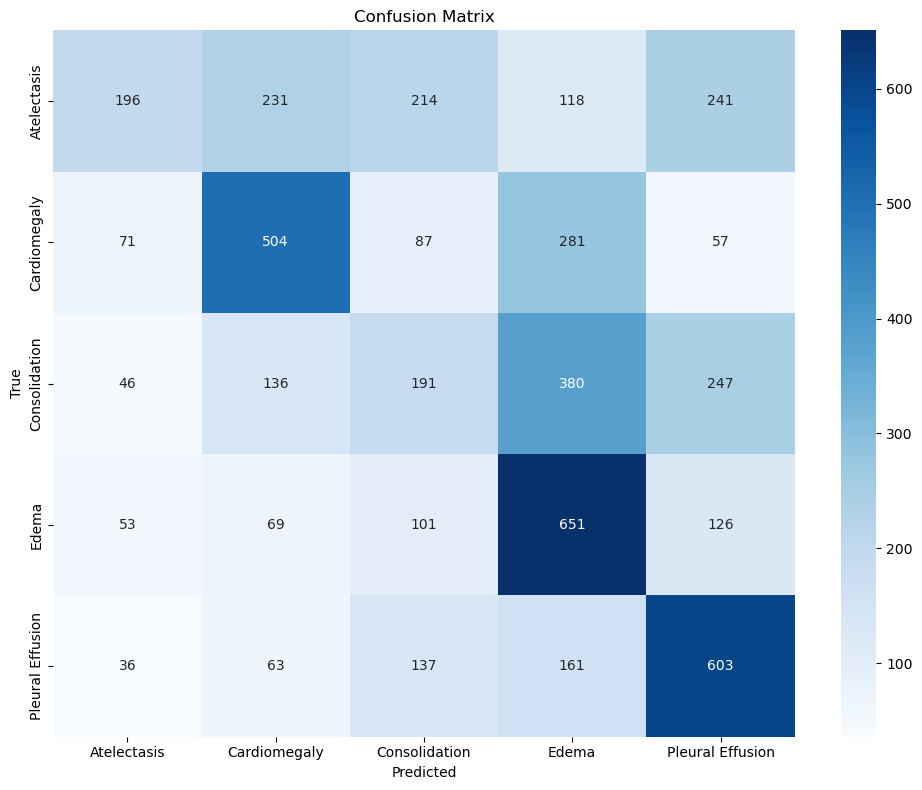

In [ ]:
def construct_prototype(k, dataset, class_names, model):
    """
    Construct prototype embeddings by sampling k examples per class.
    
    Args:
        k: number of examples to sample per class
        dataset: the calibration dataset (SuperviseImageDataset)
        class_names: list of class names
        model: MedCLIP model for encoding images
    
    Returns:
        prototypes: dict mapping class_name -> prototype embedding (tensor)
        sampled_indices: dict mapping class_name -> list of sampled indices
    """
    prototypes = {}
    sampled_indices = {}
    
    for class_name in class_names:
        # Find all indices where this class is positive
        class_idx = class_names.index(class_name)
        positive_mask = dataset.df[class_name] == 1
        positive_indices = dataset.df[positive_mask].index.tolist()
        
        if len(positive_indices) < k:
            print(f"Warning: {class_name} has only {len(positive_indices)} samples, using all of them")
            selected_indices = positive_indices
        else:
            # Randomly sample k indices
            selected_indices = np.random.choice(positive_indices, size=k, replace=False).tolist()
        
        sampled_indices[class_name] = selected_indices
        
        # Encode all sampled images
        embeddings = []
        for idx in selected_indices:
            pixel_values, label = dataset[idx]
            pixel_values = pixel_values.to(model.device)
            
            # Get image embedding
            with torch.no_grad():
                embedding = model.encode_image(pixel_values)
                # Flatten to ensure shape is [embedding_dim]
                embedding = embedding.squeeze()
            embeddings.append(embedding)
        
        # Average embeddings to create prototype
        prototype = torch.stack(embeddings).mean(dim=0)
        prototypes[class_name] = prototype
        
        print(f"{class_name}: sampled {len(selected_indices)} examples")
    
    return prototypes, sampled_indices


def evaluate_with_prototypes(prototypes, test_dataset, class_names, model, batch_size=32):
    """
    Evaluate classification using prototype-based approach.
    
    Args:
        prototypes: dict mapping class_name -> prototype embedding
        test_dataset: test dataset
        class_names: list of class names
        model: MedCLIP model
        batch_size: batch size for evaluation
    
    Returns:
        results: dict containing predictions, labels, and metrics
    """
    all_predictions = []
    all_labels = []
    
    # Create dataloader
    collator = SuperviseImageCollator(mode='multiclass')
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collator,
        num_workers=0  # Set to 0 for MPS compatibility on macOS
    )
    
    # Stack prototypes into a matrix for efficient computation
    prototype_matrix = torch.stack([prototypes[class_name] for class_name in class_names])
    # Ensure shape is [num_classes, embedding_dim]
    if prototype_matrix.dim() > 2:
        prototype_matrix = prototype_matrix.squeeze()
    
    print(f"Evaluating on {len(test_dataset)} test samples...")
    
    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values'].to(model.device)
            labels = batch['labels']
            
            # Encode batch of images
            image_embeddings = model.encode_image(pixel_values)
            # Flatten to ensure shape is [batch_size, embedding_dim]
            if image_embeddings.dim() > 2:
                image_embeddings = image_embeddings.squeeze()
            
            # Compute similarity to each prototype (cosine similarity)
            # Normalize embeddings
            image_embeddings_norm = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
            prototype_matrix_norm = prototype_matrix / prototype_matrix.norm(dim=-1, keepdim=True)
            
            # Compute similarities
            similarities = torch.matmul(image_embeddings_norm, prototype_matrix_norm.T)
            
            # Predict class with highest similarity
            predictions = similarities.argmax(dim=1)
            
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Calculate metrics
    accuracy = (all_predictions == all_labels).mean()
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Per-class accuracy
    per_class_acc = {}
    for i, class_name in enumerate(class_names):
        class_mask = all_labels == i
        if class_mask.sum() > 0:
            per_class_acc[class_name] = (all_predictions[class_mask] == all_labels[class_mask]).mean()
        else:
            per_class_acc[class_name] = 0.0
    
    results = {
        'predictions': all_predictions,
        'labels': all_labels,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'per_class_accuracy': per_class_acc
    }
    
    return results


def print_results(results, class_names):
    """Print evaluation results in a nice format."""
    print(f"\n{'='*60}")
    print(f"Overall Accuracy: {results['accuracy']:.4f}")
    print(f"{'='*60}\n")
    
    print("Per-Class Accuracy:")
    for class_name, acc in results['per_class_accuracy'].items():
        print(f"  {class_name:20s}: {acc:.4f}")
    
    print(f"\n{'='*60}")
    print("Confusion Matrix:")
    print(f"{'='*60}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        results['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


# Example usage:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set k (number of prototypes per class)
k = 10

# Construct prototypes
print(f"Constructing prototypes with k={k}...")
prototypes, sampled_indices = construct_prototype(k, calib_set, class_names, model)

# Evaluate on test set
results = evaluate_with_prototypes(prototypes, test_set, class_names, model, batch_size=32)

# Print results
print_results(results, class_names)

Constructing prototypes with k=50...
Atelectasis: sampled 50 examples
Cardiomegaly: sampled 50 examples
Consolidation: sampled 50 examples
Edema: sampled 50 examples
Pleural Effusion: sampled 50 examples
Evaluating on 5000 test samples...

Overall Accuracy: 0.4816

Per-Class Accuracy:
  Atelectasis         : 0.2920
  Cardiomegaly        : 0.6160
  Consolidation       : 0.2240
  Edema               : 0.6670
  Pleural Effusion    : 0.6090

Confusion Matrix:


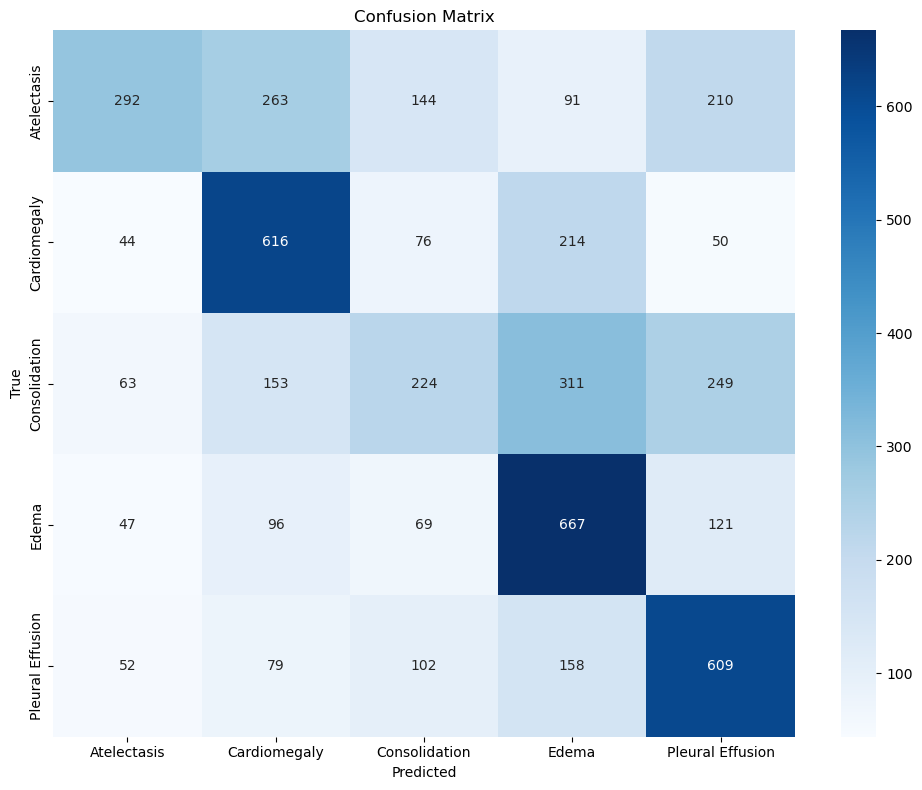

In [43]:
k = 50
print(f"Constructing prototypes with k={k}...")
prototypes, sampled_indices = construct_prototype(k, calib_set, class_names, model)

# Evaluate on test set
results = evaluate_with_prototypes(prototypes, test_set, class_names, model, batch_size=32)

# Print results
print_results(results, class_names)

In [ ]:
for i in range(20):
    pixel_values, label = calib_set[i]
    pixel_values = pixel_values.to(model.device)

    model.encode_image(pixel_values)

tensor([[ 1.1518e-04, -9.4766e-04, -2.0083e-02, -6.7734e-02,  4.7259e-02,
          7.0839e-02,  3.8346e-03,  5.0352e-03,  1.6014e-02, -1.1893e-01,
         -6.9053e-03,  2.0522e-02, -7.0651e-02, -4.2005e-02,  9.3700e-02,
          1.3274e-02, -2.6450e-02,  6.9390e-04,  3.2097e-02,  1.9502e-02,
         -2.9349e-02,  2.6198e-02, -1.1767e-02,  2.7861e-02,  3.8921e-03,
          6.2422e-02, -1.1851e-02,  1.2585e-01,  8.8973e-03,  4.1567e-02,
         -1.0928e-02, -4.7379e-02, -8.3612e-03,  9.0371e-03, -9.4016e-02,
          3.1272e-02, -1.1131e-02,  1.1536e-02,  3.8372e-02, -1.5718e-02,
         -2.0838e-02, -3.2820e-02,  2.4203e-02,  1.7212e-03,  5.4767e-03,
         -1.2800e-02,  2.0848e-02,  1.9392e-02, -8.2896e-03,  1.4292e-02,
          3.0949e-02,  8.4381e-03, -2.2233e-02, -1.5602e-02, -9.4884e-02,
         -7.0746e-03, -2.8808e-02,  4.5404e-02,  9.4233e-02,  8.6545e-02,
          1.6011e-03,  9.7197e-03,  5.3583e-02, -3.6505e-03,  3.9719e-02,
         -1.3982e-02,  3.6813e-02, -1.

In [18]:
SuperviseImageCollator

collator = SuperviseImageCollator(mode='multiclass')

# Create DataLoader
batch_size = 32
calib_dataloader = DataLoader(
    calib_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=2
)

In [ ]:
data = next(iter(calib_dataloader))

In [23]:
data['pixel_values'].shape

torch.Size([32, 3, 224, 224])